In [0]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import pandas as pd
pd.options.display.max_rows = 20
import matplotlib.pyplot as plt
import numpy as np

bg = pd.read_excel('/content/drive/My Drive/EEC 193/EEC 193B/Burn_Glucose_022020.xlsx', skiprows = 0)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
bg

,PER_CODE,Collection Date,Time Vitals,Systolic,Diastolic,MAP,HR,RR,Temp,CVP,GCS,Vent,Time_CBC,WBC,Hgb,Hct,Platelet,Time Labs,Na,K_pos,BUN,Creatnine,Glucose,Tbili,Chloride,V_CO2,PaO2,FIO2,PaCO2,HCO3,PH,Sepsis
0,21,2011-01-02,614.0,113.0,67.0,78.0,102.0,15.0,37.0,7.0,15.0,No,5.0,6.9,8.1,24.5,578.0,5.0,136.0,3.6,7.0,0.53,110.0,0.3,101.0,29.0,NaN,NaN,NaN,NaN,NaN,0
1,21,2011-01-03,600.0,137.0,67.0,85.0,105.0,16.0,37.3,7.0,15.0,No,59.0,7.8,7.9,25.1,615.0,59.0,137.0,3.7,8.0,0.55,130.0,0.3,104.0,27.0,NaN,NaN,NaN,NaN,NaN,0
2,21,2011-01-04,1000.0,124.0,56.0,73.0,104.0,18.0,37.5,7.0,15.0,No,208.0,8.9,8.7,26.6,607.0,208.0,135.0,3.4,8.0,0.53,172.0,0.3,103.0,24.0,NaN,NaN,NaN,NaN,NaN,0
3,21,2011-01-05,930.0,143.0,69.0,85.0,104.0,18.0,37.5,7.0,15.0,No,103.0,9.3,8.4,25.7,414.0,103.0,134.0,4.8,10.0,0.49,150.0,0.3,103.0,25.0,NaN,0.21,NaN,NaN,NaN,0
4,21,2011-01-06,1130.0,130.0,59.0,83.0,104.0,23.0,38.0,7.0,15.0,No,130.0,8.4,8.9,27.7,701.0,130.0,136.0,3.5,11.0,0.51,109.0,0.3,103.0,27.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6536,PCR-004-00018,2013-05-27,600.0,140.0,70.0,102.0,116.0,26.0,38.5,NaN,NaN,No,211.0,17.6,9.2,26.8,454.0,211.0,138.0,4.5,12.0,0.88,139.0,NaN,103.0,25.0,NaN,NaN,NaN,NaN,NaN,0
6537,PCR-004-00018,2013-05-28,600.0,158.0,53.0,82.0,110.0,22.0,37.8,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6538,PCR-004-00018,2013-05-29,600.0,133.0,51.0,72.0,120.0,22.0,38.5,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6539,PCR-004-00018,2013-05-30,600.0,118.0,49.0,73.0,118.0,22.0,38.8,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Data Preprocessing ##


In [0]:
def Drop_nan_row(df):
  
  drop_idx = []
  for i in range(len(df)):
    nan_count = 0
    for x in df.loc[i]:
      if str(x) == 'nan':
        nan_count += 1
    if nan_count >= 15:
      drop_idx.append(i)
    
  modified_df = df.drop(df.index[drop_idx], errors = 'ignore')
  modified_df = modified_df.reset_index(drop = True)

  return modified_df

In [0]:
def Drop_unrelated_cols(df):
  df = df.drop(columns = ['PER_CODE', 'Collection Date', 'Time Vitals', 'Time Labs', 'Time_CBC', 'Vent'], errors = 'ignore')
  return df

In [0]:
def Drop_nan_col(df):
  
  num_rows = len(df)
  for x in df:
    num_nan = 0
    for i in df[x]:
      if str(i) == 'nan':
        num_nan += 1
    
    if (num_nan/num_rows) >= 0.2:
      df = df.drop(columns = x, errors = 'ignore')
  
  return df

In [0]:
def Complete_dataset(df):

  # Change "Yes" and "No" under "Vent" to 1 and 0
  df = df.replace('No', 0)
  df = df.replace('Yes', 1)

  # drop nan or replace them with other value
  df = df.dropna()
  df = df.reset_index(drop = True)

  return df

In [0]:
def data_preprocess(df):

  # drop rows that have too many nan
  df = Drop_nan_row(df)
  # drop times and patient ids
  df = Drop_unrelated_cols(df)
  # drop cols that have too many nan
  df = Drop_nan_col(df)
  # Replace all the other nans
  df = Complete_dataset(df)

  return df

In [0]:
bg = data_preprocess(bg)

## Finding Score ##

In [10]:
pip install -U imbalanced-learn

     |████████████████████████████████| 163kB 2.7MB/s 
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
import imblearn

Using TensorFlow backend.


In [0]:
# def Scores_calculation(train_x, train_y, test_x, test_y):
#   precision_scores = [[],[]]
#   recall_scores = [[],[]]
#   f1_score_scores = [[],[]]

#   model = RandomForestClassifier()
#   for i in range(0,10):
#     model.fit(train_x, train_y)
#     predictions = model.predict(test_x)
#     report = classification_report(test_y, predictions, output_dict = True)

#     precision_scores[0].append(report['0']['precision'])
#     recall_scores[0].append(report['0']['recall'])
#     f1_score_scores[0].append(report['0']['f1-score'])
    
#     precision_scores[1].append(report['1']['precision'])
#     recall_scores[1].append(report['1']['recall'])
#     f1_score_scores[1].append(report['1']['f1-score'])

#   precision_scores_avg_0 = sum(precision_scores[0]) / 10
#   recall_scores_avg_0 = sum(recall_scores[0]) / 10
#   f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10

#   precision_scores_avg_1 = sum(precision_scores[1]) / 10
#   recall_scores_avg_1 = sum(recall_scores[1]) / 10
#   f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10

#   # print('0 precision average', precision_scores_avg_0)
#   # print('1 precision average', precision_scores_avg_1)
#   # print('0 recall average', recall_scores_avg_0)
#   # print('1 recall average', recall_scores_avg_1)
#   # print('0 f1_socre average', f1_score_scores_avg_0)
#   # print('1 f1_socre average', f1_score_scores_avg_1)
#   # print('average f1_scores', (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)

#   return (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2

## Getting Best Features ##

### Progressive Selection ###

In [0]:
# model = RandomForestClassifier()
# x = bg[['Hct', 'Platelet', 'WBC', 'Glucose']].values
# y = bg['Sepsis'].values
# train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

# scaler = RobustScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

# n_minority = len(train_y[train_y == 1])
# n_majority = int(n_minority * 2.5)
# sampling_numbers = {0: n_majority, 1: n_minority}

# rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
# train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
# train_y_rus = pd.Series(train_y_rus)
  
# score = Scores_calculation(train_x_rus, train_y_rus, test_x, test_y)
# print(score)

In [0]:
# model = RandomForestClassifier()
# temp = list(bg.columns)
# temp.remove('Hct')
# temp.remove('Platelet')
# temp.remove('WBC')
# temp.remove('Sepsis')
# temp.remove('Temp')
# temp.remove('RR')
# temp.remove('HR')
# col_use = ['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']

# for f in temp:
#   g = [f]
#   g = col_use + g

#   x = bg[g].values
#   y = bg['Sepsis'].values
#   train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

#   scaler = RobustScaler()
#   train_x = scaler.fit_transform(train_x)
#   test_x = scaler.transform(test_x)

#   n_minority = len(train_y[train_y == 1])
#   n_majority = int(n_minority * 2.5)
#   sampling_numbers = {0: n_majority, 1: n_minority}

#   rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
#   train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
#   train_y_rus = pd.Series(train_y_rus)
  
#   score = Scores_calculation(train_x_rus, train_y_rus, test_x, test_y)
#   print(g,':',score)
  

Best feature combination: ['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']

### Regressive Selection ###

In [0]:
# from sklearn.feature_selection import RFE

# col = list(bg.columns)
# col.remove('Sepsis')
# x = bg[col].values
# y = bg['Sepsis'].values
# train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

# scaler = RobustScaler()
# train_x = scaler.fit_transform(train_x)
# test_x = scaler.transform(test_x)

# n_minority = len(train_y[train_y == 1])
# n_majority = int(n_minority * 2.5)
# sampling_numbers = {0: n_majority, 1: n_minority}

# rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
# train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
# train_y_rus = pd.Series(train_y_rus)

# estimator = RandomForestClassifier()
# selector = RFE(estimator, 3, step=1)
# selector = selector.fit(train_x_rus, train_y_rus)

# new_train_x = train_x[:, selector.support_]
# new_test_x = test_x[:, selector.support_]

# model = RandomForestClassifier()

# f1_score_scores = [[],[]]

# model = RandomForestClassifier()
# for i in range(0,10):
#   model.fit(new_train_x, train_y)
#   predictions = model.predict(new_test_x)
#   report = classification_report(test_y, predictions, output_dict = True)

#   f1_score_scores[0].append(report['0']['f1-score'])
#   f1_score_scores[1].append(report['1']['f1-score'])
#   f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
#   f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10

# print((f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)

3 features: f1_score = 0.5483979297526201 \\
4 features: f1_score = 0.5807557454179925 \\
5 features: f1_score = 0.5788802053854059 \\
6 features: f1_score = 0.5769307206585933 \\
7 features: f1_score = 0.5722500953954065

## Best features + SVM + RFE ##

In [12]:
x = bg[['Hct', 'Platelet', 'WBC', 'Temp', 'RR', 'HR']].values
y = bg['Sepsis'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

scaler = RobustScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

n_minority = len(train_y[train_y == 1])
n_majority = int(n_minority * 2.5)
sampling_numbers = {0: n_majority, 1: n_minority}

rus = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=sampling_numbers)
train_x_rus, train_y_rus = rus.fit_resample(train_x, train_y)
train_y_rus = pd.Series(train_y_rus)

f1_score_scores = [[],[]]
sensitivity = []
specificity = []

# RFE: Feature ranking with recursive feature elimination.
# SVM is a classifier -> predicting discrete categorical labels
# SVR, which stands for Support Vector Regressor, is a regressor
# SVR for continuous data, SVC for discrete data
# SVM for discrete
estimator = svm.SVC(kernel="linear", probability=True)
model = RFE(estimator, 5, step=1)

for i in range(0,10):
  model.fit(train_x_rus, train_y_rus)
  predictions = model.predict(test_x)
  report = classification_report(test_y, predictions, output_dict = True)
  ss = imblearn.metrics.sensitivity_specificity_support(test_y, predictions, average='macro')
  
  sensitivity.append(ss[0])
  specificity.append(ss[1])

  f1_score_scores[0].append(report['0']['f1-score'])
  f1_score_scores[1].append(report['1']['f1-score'])

f1_score_scores_avg_0 = sum(f1_score_scores[0]) / 10
f1_score_scores_avg_1 = sum(f1_score_scores[1]) / 10
sensitivity_avg = sum(sensitivity) / 10
specificity_avg = sum(specificity) / 10

print("f1 score = ", (f1_score_scores_avg_0 + f1_score_scores_avg_1)/2)
print("sensitivity = ", sensitivity_avg)
print("specificity = ", specificity_avg)


f1 score =  0.45563674321503134
sensitivity =  0.5
specificity =  0.5


roc_auc_score =  0.6124351458796577


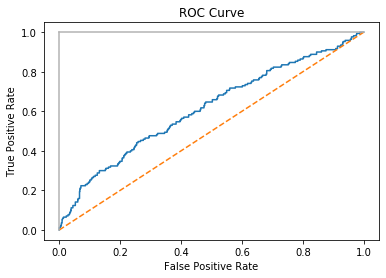

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

y_score = model.predict_proba(test_x)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(test_y, y_score)
print('roc_auc_score = ', roc_auc_score(test_y, y_score))

plt.title('ROC Curve')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()